In [136]:
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from src.main import *
from src.helper import read_csv, create_csv, prepare_dataframe
import seaborn as sns

# Helper Functions

These functions train a model on your data and use cross validation to determine the average negative mean squared error. You do not have to edit these! However, it might make sense to add new helper functions here.

In [137]:
def scoreLinear(X, y):
    """Trains a linear regression model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    regr = linear_model.LinearRegression()
    scores = cross_val_score(regr, X, y, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [138]:
def scoreBoosting(X, y):
    """Trains a gradient boosting model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='ls')
    scores = cross_val_score(clf, X, np.ravel(y), cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [139]:
def dataframeToXy(df, predict_column, feature_columns):
    """Convert the dataframe to a format usable for the ML algorithms"""
    X = df[feature_columns].values.reshape(-1, df[feature_columns].shape[1]) # all features
    y = df[[predict_column]].values.reshape(-1, 1) # values to predict
    return X, y

In [140]:
def runScoring(df, predict_column, feature_columns):
    """This runs both algorithms to determine the scores for all given features in the dataset.
    
    Parameters: 
    df (dataframe): dataframe with Score and features
    predict_column: name of the value to predict, e.g. 'Score'
    feature_columns: list of all column names that are to be used as features
  
    Returns: 
    linear: negative mean squared error of linear regression
    boost: negative mean squared error of boosting algorithm
    """
    X, y = dataframeToXy(df, predict_column, feature_columns)
    boost = scoreBoosting(X, y)
    linear = scoreLinear(X, y)
    return linear, boost

In [141]:
def runScoringSimple(df, predict_column):
    """Alternative to function above, this takes all the columns in the 
    dataframe as features except the single column which is used for the score.
    """
    all_feature_columns = list(df.columns)
    all_feature_columns.remove(predict_column)
    return runScoring(df, predict_column, all_feature_columns)

In [142]:
def createBaselineRandom(df, predict_column):
    """creates random features and returns the average score after 20 rounds"""
    np.random.seed(0)
    baseline = df[['Score']].copy()
    averageLinearScore = 0
    averageBoostingScore = 0
    rounds = 20
    for i in range(rounds):
        baseline['feature1'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature2'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature3'] = np.random.randint(0, 100, df.shape[0])
        lin, boost = runScoring(baseline, predict_column, ['feature1', 'feature2', 'feature3'])
        averageLinearScore += lin / rounds
        averageBoostingScore += boost / rounds
    print(f'linear   : {averageLinearScore}')
    print(f'boosting : {averageBoostingScore}')

# Load Data

Recommended: Make sure you have a column named 'Score', preferably as the first column, while the name of the municipality is the index.


In [143]:
ranking = read_csv('data', 'safety-ranking.csv')
# benenne Gemeinde in Gemeindename um
ranking = ranking.rename(columns={'Gemeinde': 'Gemeindename'})
ranking = ranking.set_index('Gemeindename')
ranking

C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:127: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace('---', pd.np.nan, inplace=True)


,Score,Total Anzahl Personen Sozialhilfe,Total Verunfallte Personen,Total Anzahl Unfälle 2021
Gemeindename,,,,
Doppleschwand,0.000000,0.0,0.0,0.0
Honau,0.089783,0.0,1.0,1.0
Romoos,0.161609,0.0,3.0,0.0
Flühli,0.215479,7.0,1.0,1.0
Vitznau,0.233435,9.0,0.0,2.0
...,...,...,...,...
Horw,10.055665,351.0,29.0,61.0
Ebikon,15.550368,443.0,69.0,108.0
Kriens,27.024600,1004.0,73.0,141.0


These are the features that were used to create the original ranking in Assignment 1:  
**TODO: Please write down your original features here!**


- Total Anzahl Personen Sozialhilfe
- Total Verunfallte Personen
- Total Anzahl Unfälle

# Get a first baseline for your model with random values

In [144]:
# This code creates a baseline for your model, using random features
createBaselineRandom(ranking, 'Score')

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and 

linear   : -174.09733300234578
boosting : -267.36629876029264


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and 

**WARNING**: This uses the same dataframe for both the linear model and the boosting model. In your code you will want to use different ones for the different models. Your goal is to get both of these scores to as close as 0 as possible and most likely you will need to do different steps for linear regression and for gradient boosting and therefore have different features. 

# Get a second baseline by using all features you have

In [145]:
# this assumes we have a dataframe with a column named Score and all other columns are features.
# You might have to change this code if your dataframe looks different.

prepare_dataframe(ranking)
#df_final = read_csv('data', 'engineering.csv')
#df_final = df_final.set_index('Gemeindename')
#df_final['Score'] = ranking['Score']
#unset index
#df_final.reset_index(inplace=True)

#create_csv('data','engineering_final.csv',df_final)
df_final = read_csv('data', 'engineering_final.csv')
df_final = df_final.set_index('Gemeindename')
df_final = df_final.drop(columns=['Total Anzahl Dossiers'])
df_final = df_final.drop(columns=['Total Sozialhilfequote'])
df_final = df_final.drop(columns=['Total Sozialhilfequote Schweizer'])
df_final = df_final.drop(columns=['Total Sozialhilfequote Ausländer'])
df_final = df_final.drop(columns=['Rank'])
df_final = df_final.drop(columns=['überiges Eigentkapital'])

linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

df_final

C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df_coordinates['Ortschaftsname'] = df_coordinates['Ortschaftsname'].str.replace(' b. Willisau', '')


linear   : -156.51810283853354
boosting : -74.19020168086051


C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:127: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace('---', pd.np.nan, inplace=True)
C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:127: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace('---', pd.np.nan, inplace=True)
C:\Users\Fabio\Documents\6. Semester\dawr\dawr_assignment2_fabioryser\src\main.py:127: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace('---', pd.np.nan, inplace=True)
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
 

,Score,Alter 0-17,Alter 18-64,Alter 65+,obligatorische Schule,sekundarstufe I,tertiärstufe,Personenschaden absolut mit Personenschaden,Personenschaden pro 1000 Einwohner,Durchschnitt Anzahl 2017-2021,...,Total Passiven,Fremdkapital,Eigenkapital,Spezielfinanzierung EK,Fond im EK,Aufwertungsreserven,Bilanzüberschuss,Anzahl Einwohner,Total Fläcke km2,Anzahl Wohngebäude
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Adligenswil,1.203089,1.2,0.9,0.2,0.0,0.2,0.0,3,0.5,4.0,...,76818669,43315758,33502911,6979702,299028,0,26224182,1746.0,39.30,588
Aesch,0.520740,0.5,1.2,0.0,0.0,0.0,0.0,1,0.8,3.0,...,21466150,7704460,13761690,8167324,0,2860,5591506,1827.0,108.17,1191
Alberswil,0.700305,2.6,1.3,0.0,0.0,0.0,0.0,4,6.0,3.0,...,8323012,4375329,3947683,1287875,30763,0,2629044,639.0,37.39,223
Altbüron,0.718262,6.1,2.0,0.0,0.0,0.0,0.0,1,1.0,2.0,...,12044450,8502752,3541699,1254746,38801,0,2248152,1725.0,40.31,517
Altishofen,1.005567,2.1,1.3,0.0,0.0,0.0,0.0,5,2.5,4.0,...,27343168,6820858,20522311,4876009,56841,4775488,10813973,1263.0,37.76,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Honau,0.089783,0.0,0.0,0.0,0.0,0.0,0.0,1,2.4,1.0,...,5414822,2694182,2720640,1765375,163816,0,791449,14739.0,12.86,2145
Rain,1.490393,0.0,0.0,0.0,0.0,0.0,0.0,12,4.1,5.0,...,51272154,35526066,15746088,4744277,28687,2159032,8814092,28613.0,27.30,3312
Romoos,0.161609,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,7584044,1241493,6342551,579826,204486,1365246,4192993,10382.0,5.83,1314


# Do your own feature engineering here

Your goal is to find the right features to get both scores as close to 0 as possible. Add more columns to your dataframe and choose which ones of those you will use for the machine learning models. Use the methods discussed in class to improve your results even further.

# add new features to dataframe

In [146]:
df_final['Einwohner pro Wohngebäude'] = df_final['Anzahl Einwohner'] / df_final['Anzahl Wohngebäude']
df_final['Durchschnittliches Einkommen pro Kopf'] = df_final['Median Einkommen'] / df_final['Anzahl Einwohner']
df_final['Fläche pro Wohngebäude'] = df_final['Total Fläcke km2'] / df_final['Anzahl Wohngebäude']

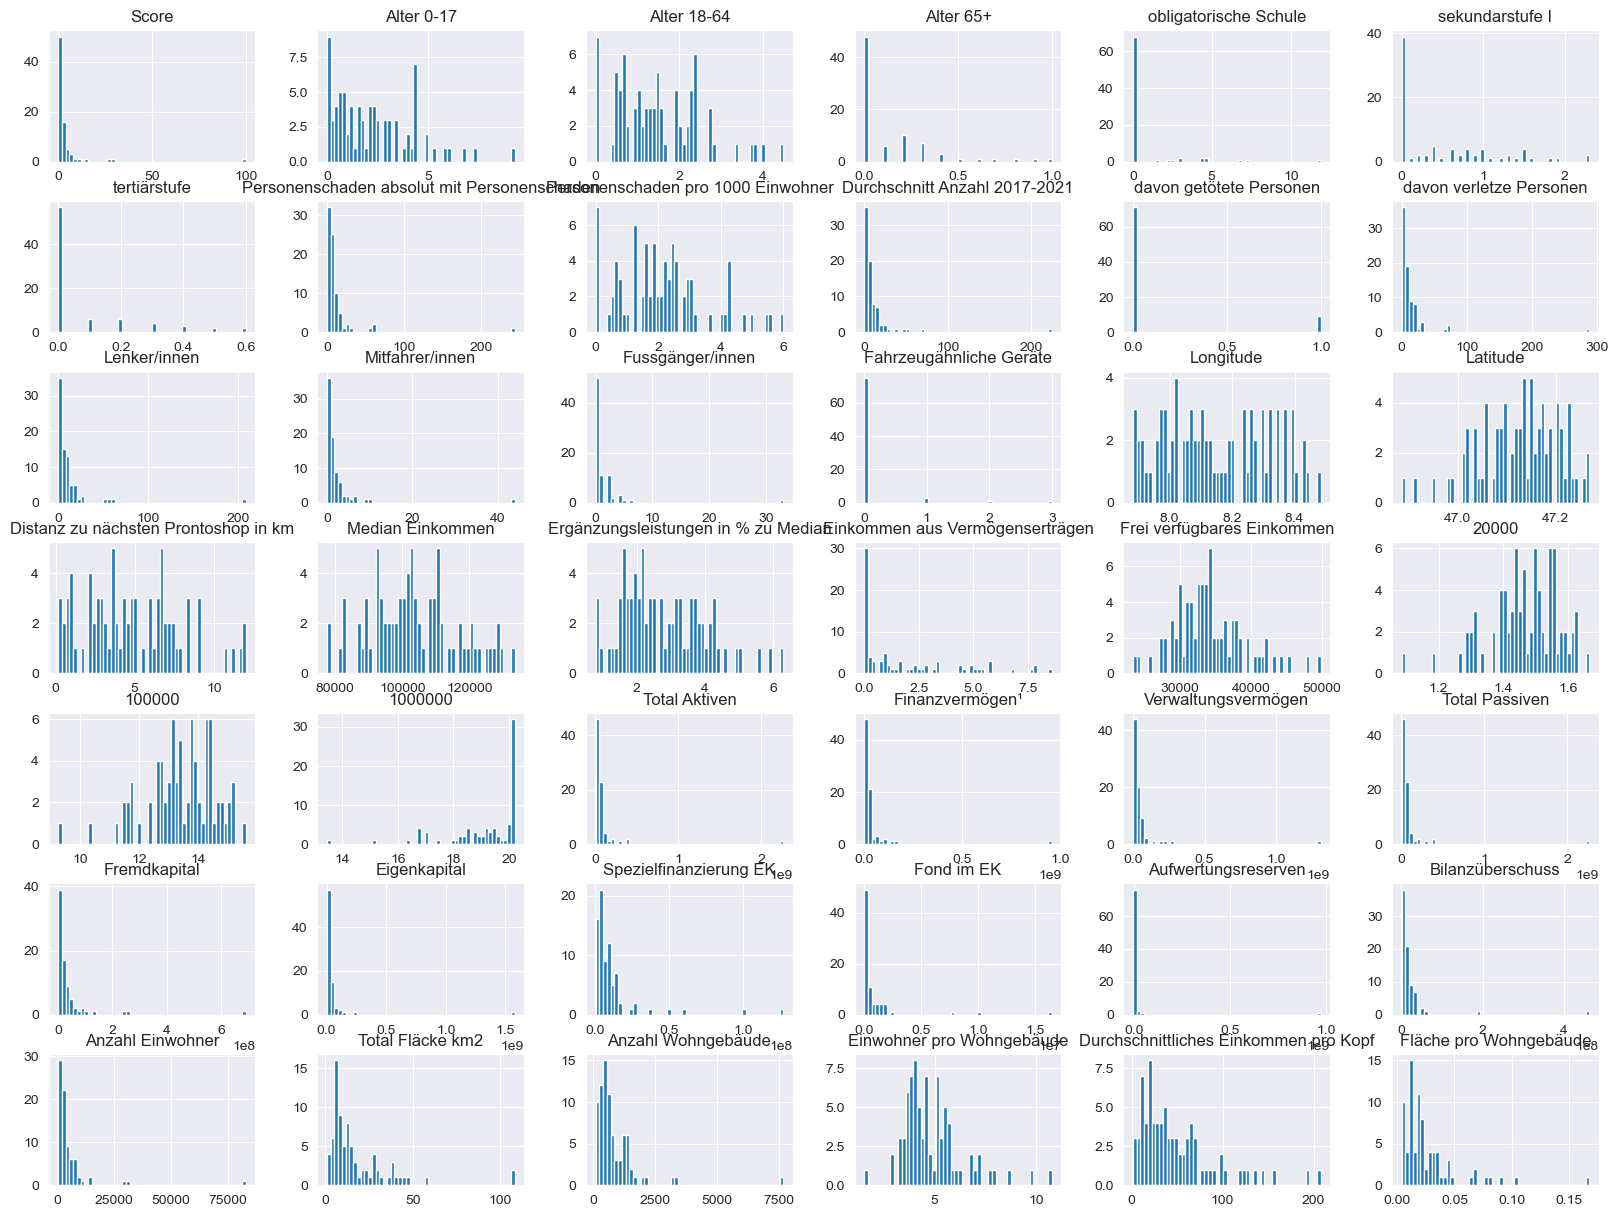

In [147]:
df_final.hist(bins=50, figsize=(20,15))
plt.show()

Median Einkommen                              -0.298818
Distanz zu nächsten Prontoshop in km          -0.288036
Frei verfügbares Einkommen                    -0.212563
Einkommen aus Vermögenserträgen               -0.199647
Latitude                                      -0.158034
100000                                        -0.120581
20000                                         -0.120581
1000000                                       -0.091229
Einwohner pro Wohngebäude                     -0.090359
Anzahl Einwohner                              -0.064435
Anzahl Wohngebäude                            -0.056806
Durchschnittliches Einkommen pro Kopf         -0.055907
Fläche pro Wohngebäude                         0.020555
Total Fläcke km2                               0.072561
Alter 65+                                      0.100215
Personenschaden pro 1000 Einwohner             0.104257
Longitude                                      0.175628
davon getötete Personen                        0

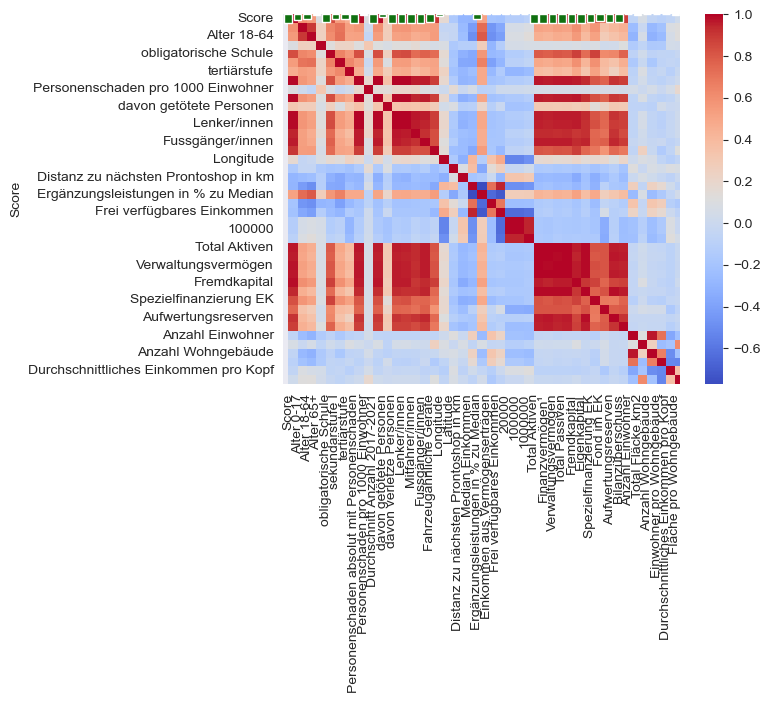

In [148]:
#TODO: Insert all your code here
# Korrelationsanalyse
corr_matrix = df_final.corr(method='pearson')
sns.heatmap(corr_matrix, cmap='coolwarm')
sns.barplot(x=corr_matrix.columns, y=corr_matrix.loc['Score',:], color='g')
corr_matrix.loc['Score',:].sort_values()

# Erste Features ausschliessen

In [149]:
df_final = df_final.drop(columns=['Durchschnitt Anzahl 2017-2021']) # war direkt abhängig von den Features die für den Score verwendet wurden
# Schliesse alle Featues aus, die eine Korrelation von weniger als 0.1 haben
df_final = df_final.drop(columns=['Longitude', 'Personenschaden pro 1000 Einwohner', 'Alter 65+', 'Total Fläcke km2', 'Fläche pro Wohngebäude', 'Latitude', 'Einkommen aus Vermögenserträgen', '100000', '1000000', '20000'])

linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

linear   : -116.7010776870135
boosting : -74.14150810970311


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


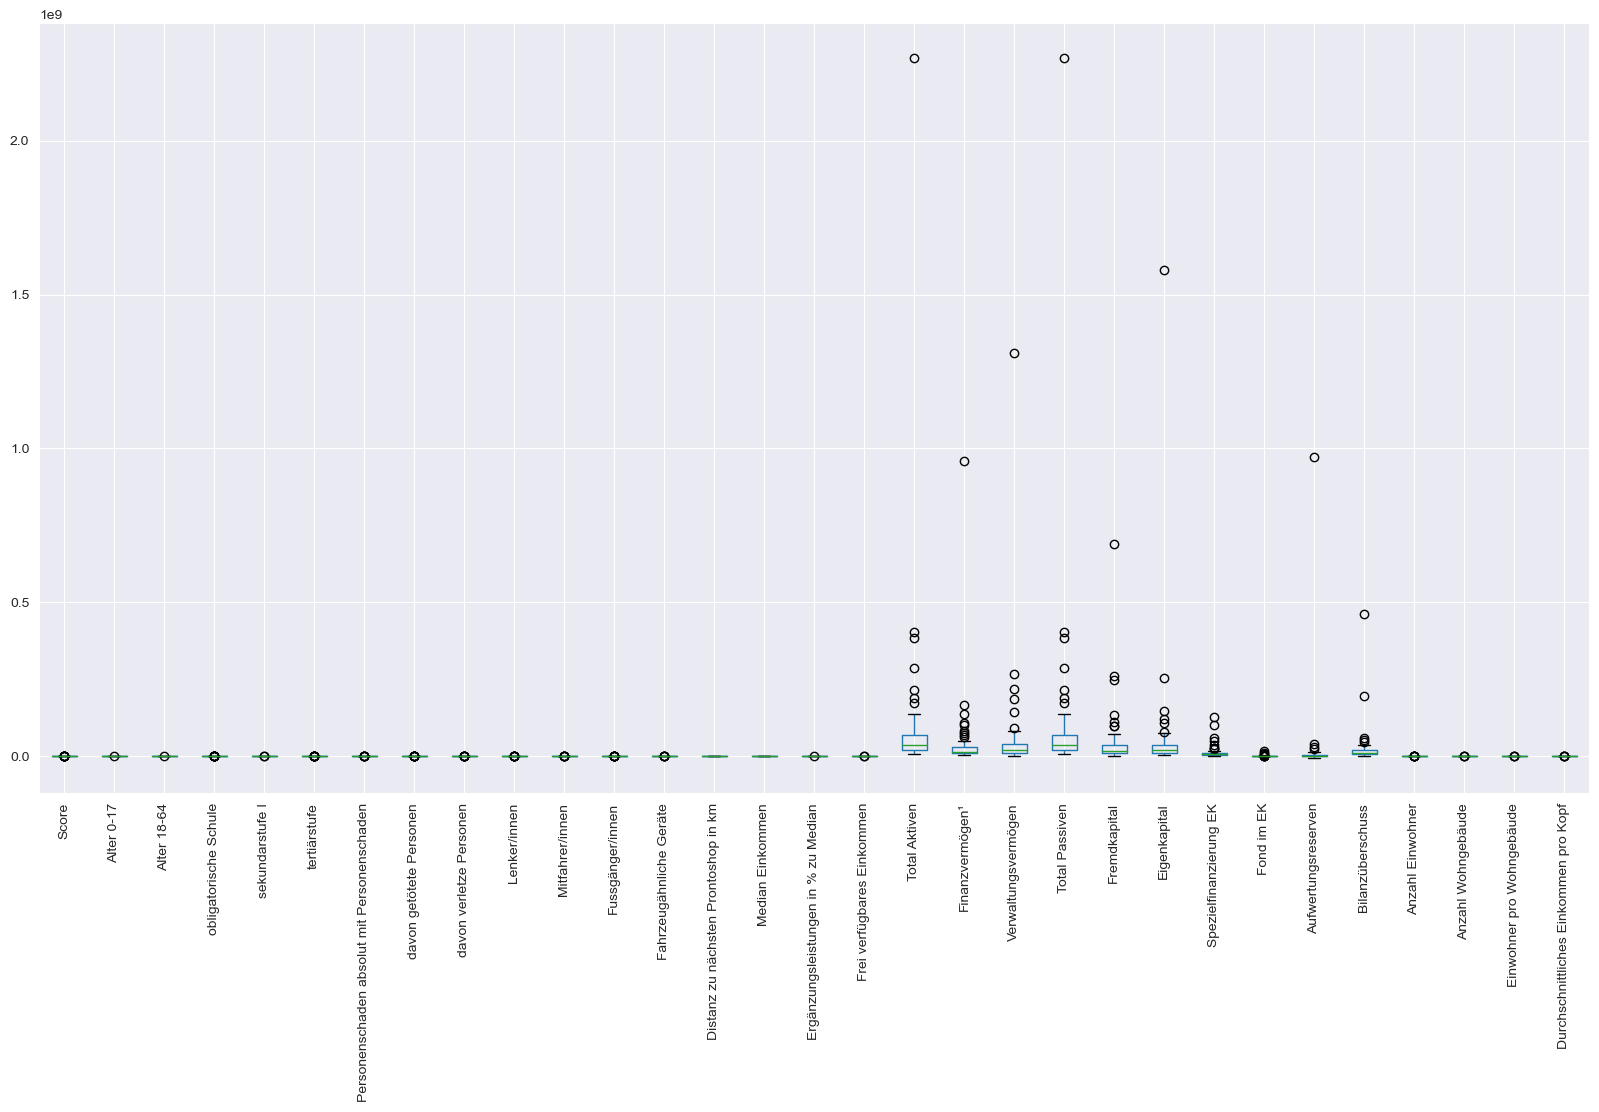

In [150]:
# boxplote die Features die featuers in df_final um Ausreiser zu sehen
fig, ax = plt.subplots(figsize=(20, 10))
df_final.boxplot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Zeige das Diagramm an
plt.show()


# Feature Transformation
Anhand der Boxplots wurden die Ausreiser ersichtlich. Normalisierung der auffälligen Spalten.

In [159]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df_final)
df = pd.DataFrame(scaled_data, columns=df_final.columns)
linear, boost = runScoringSimple(df, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

linear   : -0.0038286739255669663
boosting : -0.008102838578560688


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


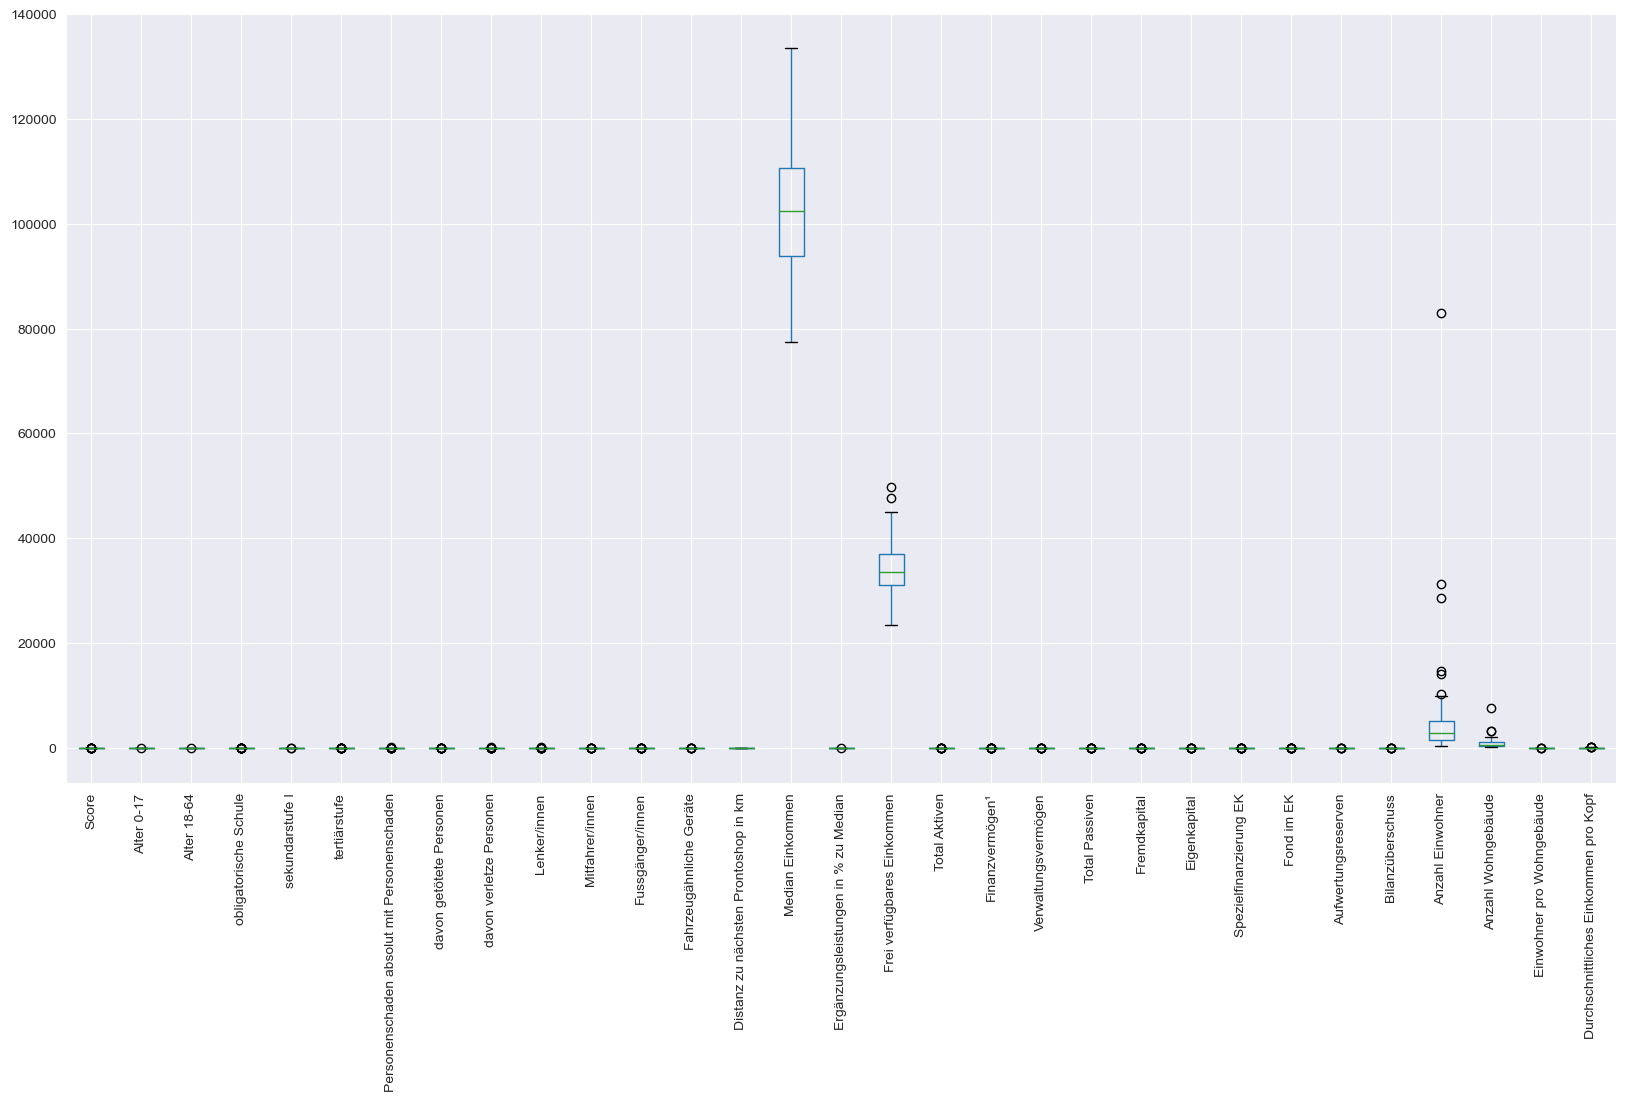

linear   : -114.88792144149095
boosting : -74.14150810970311


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [151]:
features_to_transform = ['Total Aktiven', 'Finanzvermögen¹', 'Verwaltungsvermögen', 'Total Passiven','Fremdkapital','Eigenkapital','Spezielfinanzierung EK', 'Fond im EK', 'Aufwertungsreserven','Bilanzüberschuss']
scaler = MinMaxScaler()
df_final[features_to_transform] = scaler.fit_transform(df_final[features_to_transform])
# convert the scaled features to a dataframe
fig, ax = plt.subplots(figsize=(20, 10))
df_final.boxplot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Zeige das Diagramm an
plt.show()
linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

In [152]:
# Anzahl Einwohner log anwenden
df_final['Anzahl Einwohner'] = np.log(df_final['Anzahl Einwohner'])
df_final['Anzahl Wohngebäude'] = np.log(df_final['Anzahl Wohngebäude'])
df_final['Durchschnittliches Einkommen pro Kopf'] = np.log(df_final['Durchschnittliches Einkommen pro Kopf'])
# Frei verfügbares Einkommen min/max anwenden
df_final['Frei verfügbares Einkommen'] = (df_final['Frei verfügbares Einkommen'] - df_final['Frei verfügbares Einkommen'].min()) / (df_final['Frei verfügbares Einkommen'].max() - df_final['Frei verfügbares Einkommen'].min())
df_final['Median Einkommen'] = (df_final['Median Einkommen'] - df_final['Median Einkommen'].min()) / (df_final['Median Einkommen'].max() - df_final['Median Einkommen'].min())
df_final['Distanz zu nächsten Prontoshop in km'] = (df_final['Distanz zu nächsten Prontoshop in km'] - df_final['Distanz zu nächsten Prontoshop in km'].min()) / (df_final['Distanz zu nächsten Prontoshop in km'].max() - df_final['Distanz zu nächsten Prontoshop in km'].min())
linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


linear   : -103.66368327359372
boosting : -74.14157247504801


Um Overfitting zu verhindern werden nun die Features mit der höchsten Korrelation mit dem Score ausgeschlossen.

In [153]:
df_final = df_final.drop(columns=['Personenschaden absolut mit Personenschaden', 'davon verletze Personen','Lenker/innen','Mitfahrer/innen','Fussgänger/innen'])
linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


linear   : -38.286740643679714
boosting : -81.06707186228222


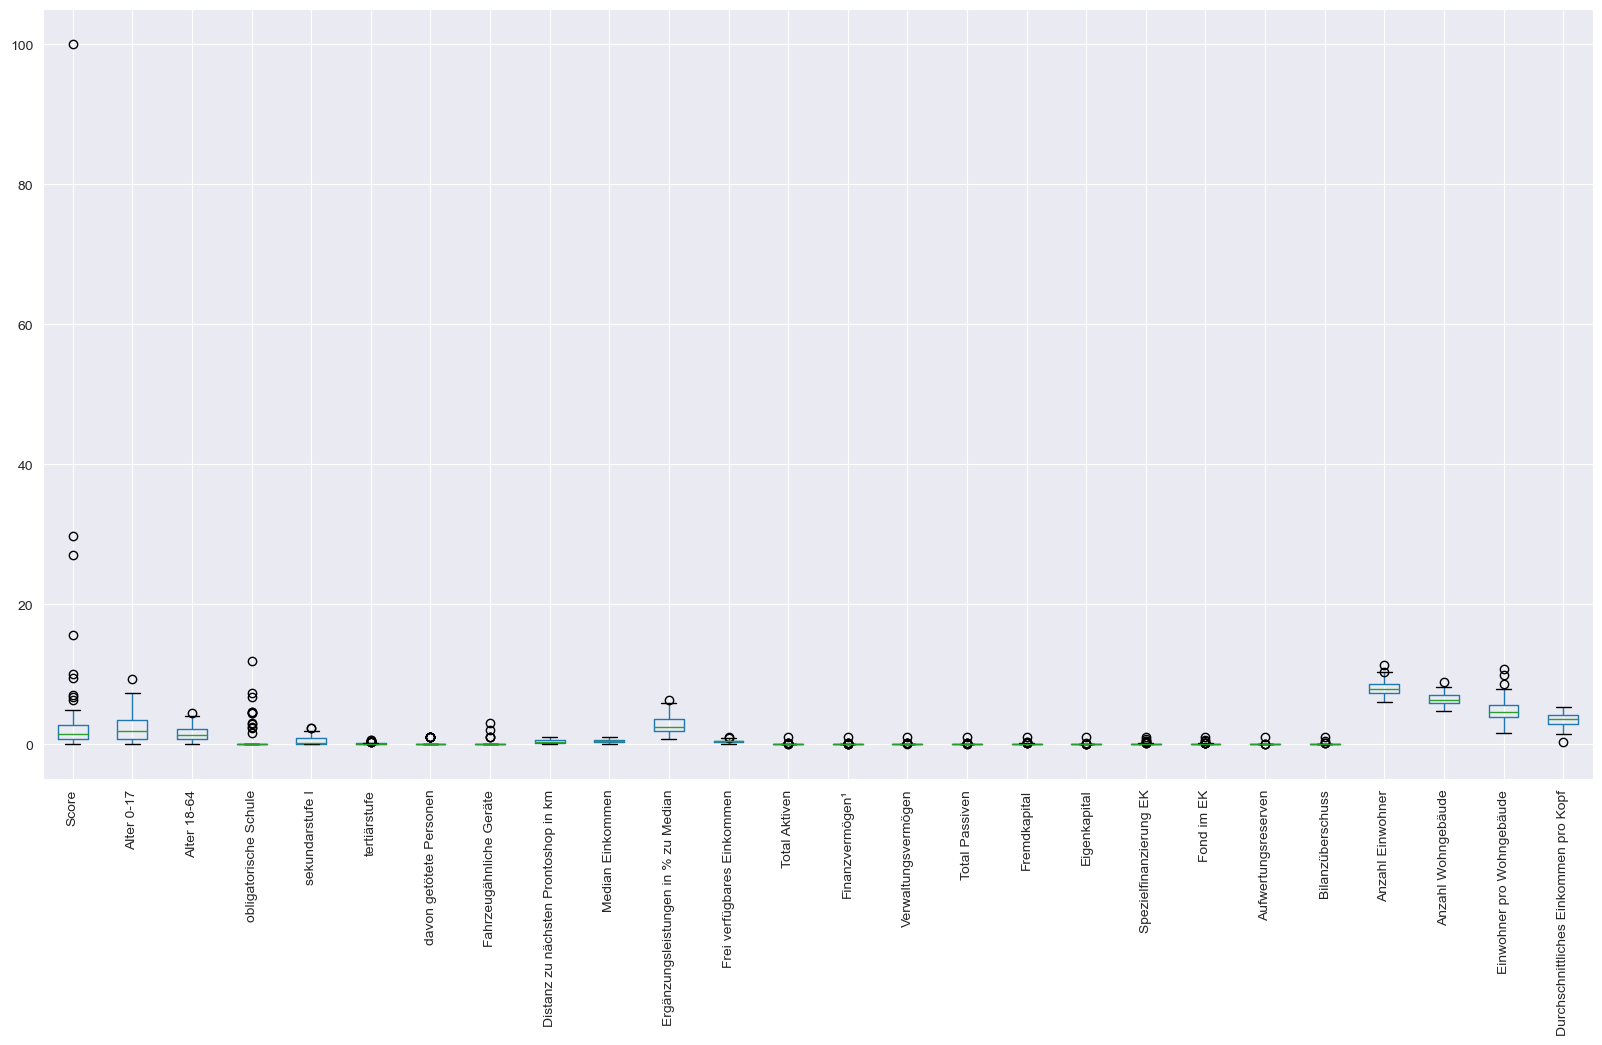

In [154]:
fig, ax = plt.subplots(figsize=(20, 10))
df_final.boxplot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Zeige das Diagramm an
plt.show()

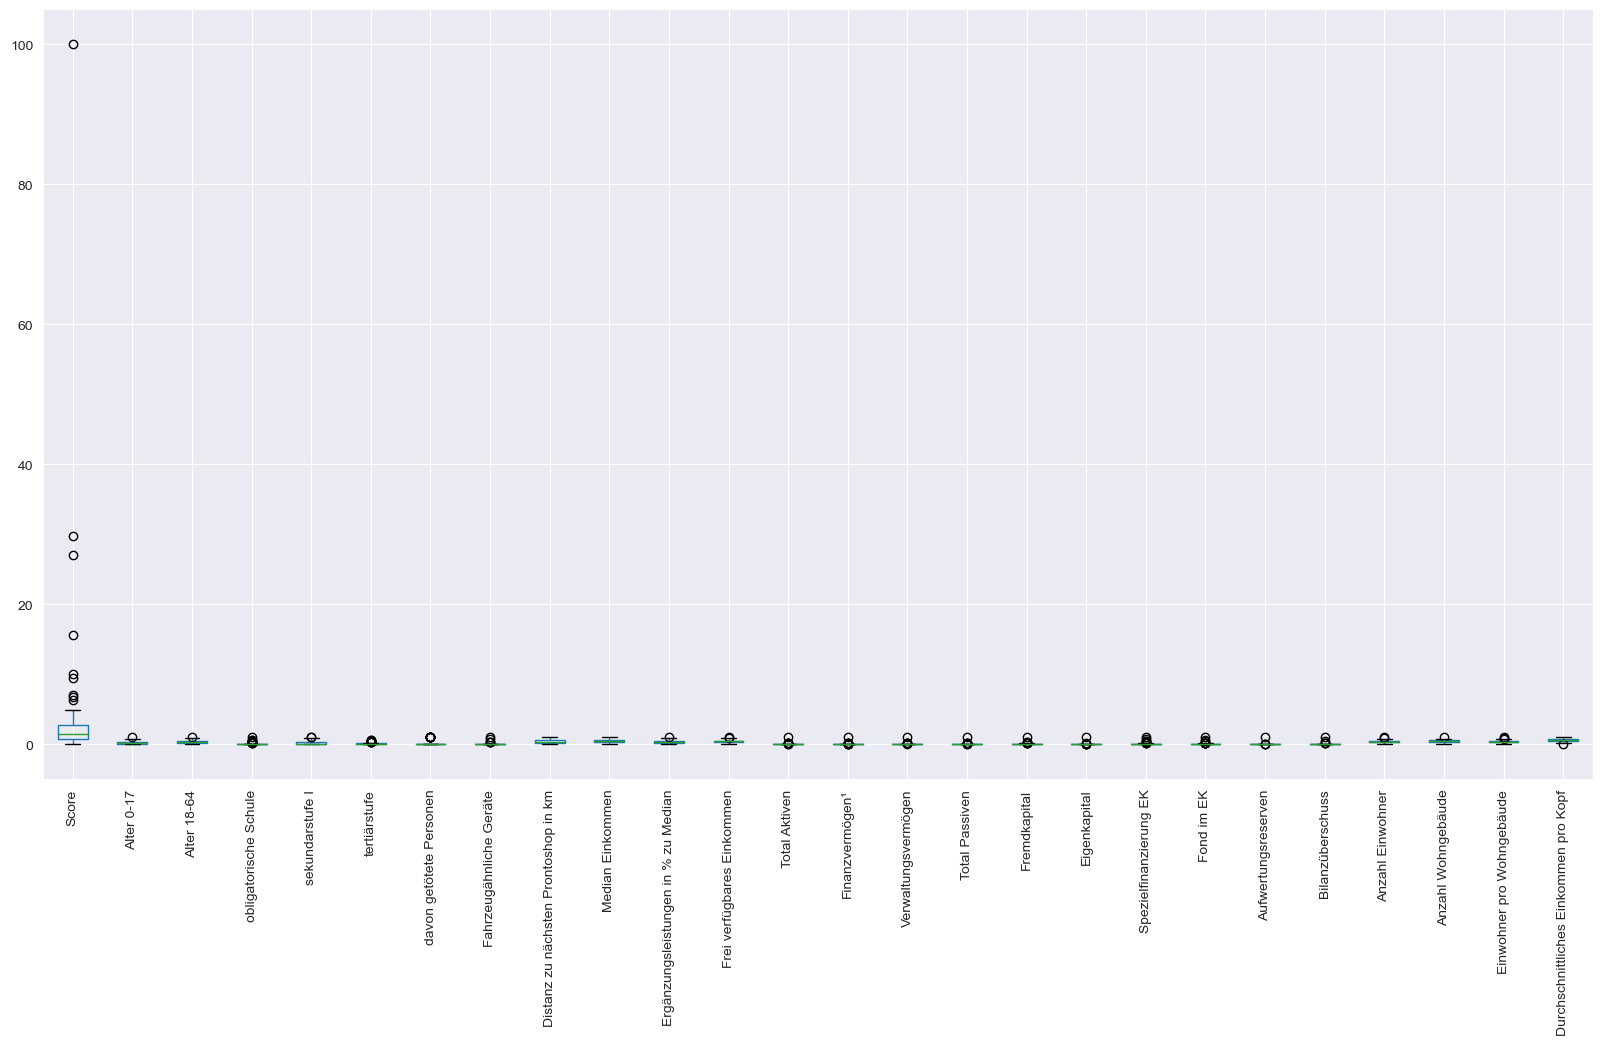

linear   : -38.28673909317053
boosting : -78.92008093408116


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [155]:
# min/max anwenden
df_final['Anzahl Einwohner'] = (df_final['Anzahl Einwohner'] - df_final['Anzahl Einwohner'].min()) / (df_final['Anzahl Einwohner'].max() - df_final['Anzahl Einwohner'].min())
df_final['Anzahl Wohngebäude'] = (df_final['Anzahl Wohngebäude'] - df_final['Anzahl Wohngebäude'].min()) / (df_final['Anzahl Wohngebäude'].max() - df_final['Anzahl Wohngebäude'].min())
df_final['Einwohner pro Wohngebäude'] = (df_final['Einwohner pro Wohngebäude'] - df_final['Einwohner pro Wohngebäude'].min()) / (df_final['Einwohner pro Wohngebäude'].max() - df_final['Einwohner pro Wohngebäude'].min())
df_final['Durchschnittliches Einkommen pro Kopf'] = (df_final['Durchschnittliches Einkommen pro Kopf'] - df_final['Durchschnittliches Einkommen pro Kopf'].min()) / (df_final['Durchschnittliches Einkommen pro Kopf'].max() - df_final['Durchschnittliches Einkommen pro Kopf'].min())
df_final['Ergänzungsleistungen in % zu Median'] = (df_final['Ergänzungsleistungen in % zu Median'] - df_final['Ergänzungsleistungen in % zu Median'].min()) / (df_final['Ergänzungsleistungen in % zu Median'].max() - df_final['Ergänzungsleistungen in % zu Median'].min())
df_final['obligatorische Schule'] = (df_final['obligatorische Schule'] - df_final['obligatorische Schule'].min()) / (df_final['obligatorische Schule'].max() - df_final['obligatorische Schule'].min())
df_final['Alter 0-17'] = (df_final['Alter 0-17'] - df_final['Alter 0-17'].min()) / (df_final['Alter 0-17'].max() - df_final['Alter 0-17'].min())
df_final['Alter 18-64'] = (df_final['Alter 18-64'] - df_final['Alter 18-64'].min()) / (df_final['Alter 18-64'].max() - df_final['Alter 18-64'].min())
df_final['sekundarstufe I'] = (df_final['sekundarstufe I'] - df_final['sekundarstufe I'].min()) / (df_final['sekundarstufe I'].max() - df_final['sekundarstufe I'].min())
df_final['Fahrzeugähnliche Geräte'] = (df_final['Fahrzeugähnliche Geräte'] - df_final['Fahrzeugähnliche Geräte'].min()) / (df_final['Fahrzeugähnliche Geräte'].max() - df_final['Fahrzeugähnliche Geräte'].min())
fig, ax = plt.subplots(figsize=(20, 10))
df_final.boxplot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Zeige das Diagramm an
plt.show()

linear, boost = runScoringSimple(df_final, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

# Feature Selection

In [158]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# Set up estimator and RFE object
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=7)

# Select features using RFE
X = df_final.drop('Score', axis=1)
y = df_final['Score']
rfe.fit(X, y)

# Get selected feature names and scores
selected_features = X.columns[rfe.support_]
linear_score, boosting_score = runScoringSimple(df_final[selected_features.union(['Score'])], 'Score')

print(f"Selected features: {list(selected_features)}")
print(f"Linear score: {linear_score}")
print(f"Boosting score: {boosting_score}")

Selected features: ['Total Aktiven', 'Finanzvermögen¹', 'Verwaltungsvermögen', 'Total Passiven', 'Fremdkapital', 'Eigenkapital', 'Aufwertungsreserven']
Linear score: -14.159784371900088
Boosting score: -78.88899786890171


C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\Users\Fabio\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
